In [1]:
import numpy as np

def f(x):
  return 3*x**2 - 4*x + 5

In [2]:
xs = np.arange(-5, 5, 0.25)
xs
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

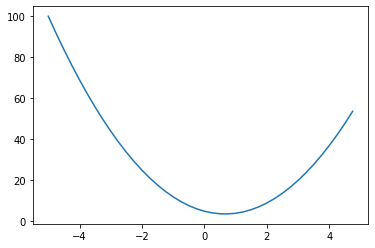

In [3]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)

In [4]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [5]:

h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [290]:
from posixpath import relpath
from logging import setLogRecordFactory
import math

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda : None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward() :
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    
    out._backward = _backward
    
    return out

  def __radd__(self, other):
    return self + other

  def backward(self) :
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)
    self.grad = 1.0

    for node in reversed(topo):
        node._backward()

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward() :
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    
    out._backward = _backward
    
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers"
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward() :
      self.grad += other * self.data**(other-1) * out.grad
    
    out._backward = _backward
    
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward() :
      self.grad += (1-t**2) * out.grad

    out._backward = _backward

    return out

  def exp(self):
    n = self.data
    t = math.exp(n)
    out = Value(t, (self, ), 'exp')

    def _backward() :
      self.grad += t * out.grad

    out._backward = _backward   
    
    return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

In [291]:
-1.0 + Value(2.0)

Value(data=1.0)

In [292]:
Value(2.0) + 1.0

Value(data=3.0)

In [295]:
Value(1.0)*-1

Value(data=-1.0)

In [93]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d= e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [94]:
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

e = a * b
d = e + c
L = d * f
print(L.data)

-8.0


In [95]:
from graphviz import Digraph

In [96]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

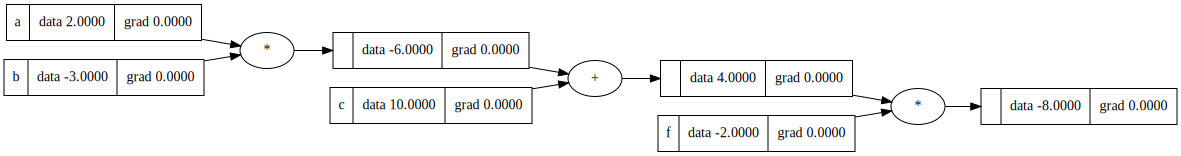

In [97]:
draw_dot(L)

In [98]:
L.grad = 1.0
f.grad = d.data * L.grad
d.grad = f.data * L.grad
c.grad = 1.0 * d.grad
e.grad = 1.0 * d.grad
b.grad = a.data * e.grad
a.grad = b.data * e.grad

In [99]:
def lol():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d= e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d= e + c; d.label = 'd'
  f = Value(-2.0+h, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()

3.9999999999995595


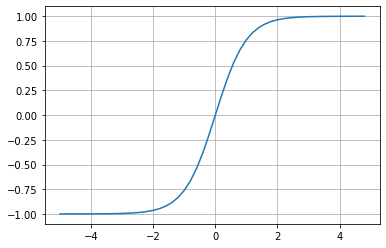

In [100]:
xs = np.arange(-5, 5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid()


In [108]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----
#o = n.tanh()

e = (2*n).exp()
o = (e-1)/(e+1)

#---
o.label = 'o'

o.backward()

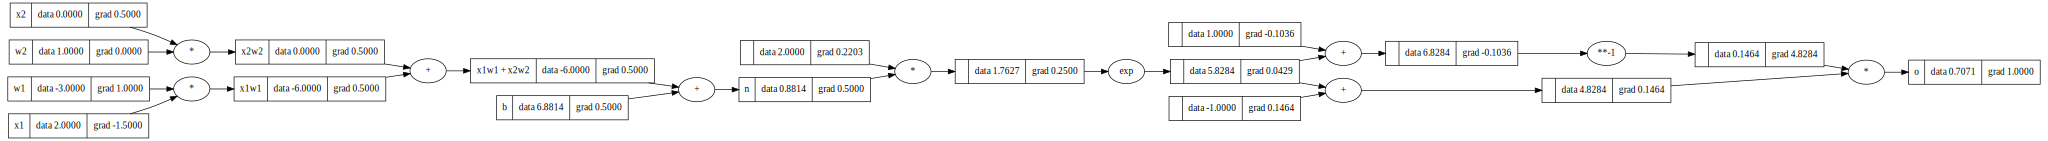

In [109]:
draw_dot(o)

In [69]:
o.backward()

In [64]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

In [61]:
# topological order all of the children in the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [49]:
o.grad = 1.0

In [51]:
o._backward()

In [53]:
n._backward()

In [55]:
b._backward()

In [57]:
x1w1x2w2._backward()

In [59]:
x2w2._backward()
x1w1._backward()

In [36]:
o.grad = 1.0
n.grad = 1-o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad

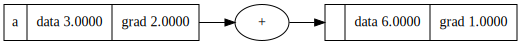

In [72]:
a = Value(3.0, label='a')
b = a + a
b.backward()
draw_dot(b)

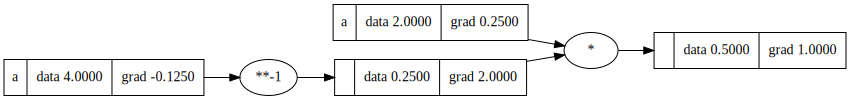

In [75]:
a = Value(2.0, label='a')
b = Value(4.0, label='a')
c = a / b
c.backward()
draw_dot(c)

In [110]:
import torch

In [120]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print("------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [171]:
w = [random.uniform(-1,1) for _ in range(2)]
x = [2.0, 3.0]
l = [(f"{wi}*{xi}", wi*xi) for wi, xi in zip(w, x)]

In [173]:
sum(wx for _, wx in l)

-1.2753820948041361

In [328]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out
    def parameters(self):
      return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
      return [p for n in self.neurons for p in n.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

In [469]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9847496640036014)

In [470]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, 1.0, 1.0]

In [483]:
for k in range(30):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout*-1 + yget)**2 for yget, yout in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0

  # backward pass
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  # status
  print(k, loss.data)

0 0.001192194724404446
1 0.0011887317146451561
2 0.0011852886137643714
3 0.0011818652511826821
4 0.001178461458259796
5 0.0011750770682671025
6 0.0011717119163606108
7 0.001168365839554561
8 0.0011650386766952042
9 0.0011617302684353242
10 0.0011584404572089076
11 0.0011551690872063786
12 0.0011519160043502838
13 0.0011486810562712853
14 0.00114546409228457
15 0.0011422649633666731
16 0.0011390835221327014
17 0.0011359196228138777
18 0.0011327731212355111
19 0.0011296438747952467
20 0.0011265317424417592
21 0.0011234365846537193
22 0.0011203582634191902
23 0.0011172966422152107
24 0.0011142515859878597
25 0.0011112229611325792
26 0.0011082106354747758
27 0.0011052144782507532
28 0.00110223436008905
29 0.0010992701529918593


In [484]:
ypred

[Value(data=0.9936133355738661),
 Value(data=-0.9725981928154263),
 Value(data=0.9896174638360755),
 Value(data=0.9858640679004157)]

In [454]:
ypred = [n(x) for x in xs]
loss = sum((yout*-1 + yget)**2 for yget, yout in zip(ys, ypred))
loss

Value(data=3.243313338111271e-05)

In [455]:
ypred

[Value(data=0.9999999999999986),
 Value(data=-0.9943049904845459),
 Value(data=0.9999999999910646),
 Value(data=0.9999999999166266)]

In [452]:
loss.backward()

In [453]:
for p in n.parameters():
  p.data += -0.1 * p.grad

In [457]:
n.parameters()

[Value(data=-0.6620721047159956),
 Value(data=0.4616569247884869),
 Value(data=1.1325702465007172),
 Value(data=-0.6761712397131845),
 Value(data=-2.932902083103186),
 Value(data=3.506172407750124),
 Value(data=-0.3555650080810067),
 Value(data=-0.8065905434868387),
 Value(data=1.2333817430120775),
 Value(data=-0.8954716750182816),
 Value(data=0.8411560047045518),
 Value(data=-0.5278417422462356),
 Value(data=1.1035105216342893),
 Value(data=0.3921590827293167),
 Value(data=-0.8116653321215372),
 Value(data=-0.38324902400689054),
 Value(data=-1.3206050363656936),
 Value(data=-0.8448092806522999),
 Value(data=2.400730552830492),
 Value(data=1.5774622452925184),
 Value(data=-0.4746919589225234),
 Value(data=-0.3671331940492184),
 Value(data=0.6937905826757361),
 Value(data=-1.565458272325447),
 Value(data=-0.2043800221335644),
 Value(data=0.02922422194064485),
 Value(data=-0.8454766786344141),
 Value(data=0.7346322182684681),
 Value(data=1.0516708806590456),
 Value(data=-0.37838653714327